In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

import kagglehub

# Point KaggleHub to the current folder where kaggle.json is located
os.environ["KAGGLE_CONFIG_DIR"] = os.getcwd()

# Download the dataset
path = kagglehub.dataset_download("evilspirit05/ecg-analysis")

print("Dataset downloaded successfully!")
print("Path to dataset files:", path)

/home/oconnecs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded successfully!
Path to dataset files: /home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2


In [3]:
# List the contents of the dataset root folder
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    print(f"  Subfolders: {dirs[:5]}")
    print(f"  Files: {files[:5]}")
    break  # remove 'break' if you want to see full structure

Folder: /home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2
  Subfolders: ['ECG_DATA']
  Files: []


In [4]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [5]:
# Transformations (InceptionV3 requires 299x299 input)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Dataset loading
data_dir = path

class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        class_map = {
            "History of MI": 0,
            "abnormal heartbeat": 1,
            "Myocardial Infarction": 2,
            "Normal Person": 3
        }

        for class_name, label in class_map.items():
            for subdir, _, files in os.walk(root_dir):
                if class_name in subdir:
                    for file in files:
                        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                            self.image_paths.append(os.path.join(subdir, file))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label

# Example usage:
train_dir = "/home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2/ECG_DATA/train"
test_dir = "/home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2/ECG_DATA/test"

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

In [14]:
# Load datasets
train_dataset = ECGDataset(train_dir, transform=transform)
test_dataset = ECGDataset(test_dir, transform=transform)

# Split train into train/val (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train size: {len(train_set)}")
print(f"Validation size: {len(val_set)}")
print(f"Test size: {len(test_dataset)}")

Train size: 2418
Validation size: 605
Test size: 928


In [15]:
# Load InceptionV3 pretrained on ImageNet
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Freeze base layers to keep pretrained features
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4)  # 4-class classification
)

# InceptionV3 also has an auxiliary classifier (for training stability)
num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 4)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model ready on device: {device}")

Model ready on device: cuda


In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler: reduce LR by 0.5 every 3 epochs
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Early stopping setup
best_val_loss = float('inf')
patience = 3
trigger_times = 0

In [17]:
# Gradual unfreezing setup
def unfreeze_layers(model, n_unfreeze_blocks=1):
    """
    Unfreezes the last n_inception blocks of InceptionV3 for fine-tuning.
    """
    # Each Inception block is part of the mixed modules (e.g., Mixed_5b, Mixed_6a, etc.)
    inception_blocks = [model.Mixed_5b, model.Mixed_5c, model.Mixed_5d,
                        model.Mixed_6a, model.Mixed_6b, model.Mixed_6c, model.Mixed_6d, model.Mixed_6e,
                        model.Mixed_7a, model.Mixed_7b, model.Mixed_7c]

    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last `n_unfreeze_blocks`
    for block in inception_blocks[-n_unfreeze_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    print(f"Unfroze the last {n_unfreeze_blocks} inception blocks for fine-tuning.")


# Example: start frozen, unfreeze gradually
epochs_before_unfreeze = 5  # train only the classifier for 5 epochs
unfreeze_schedule = [1, 3, 5]  # number of inception blocks to unfreeze at milestones

In [19]:
from tqdm import tqdm

# --- Hyperparameters ---
num_epochs = 15
learning_rate = 1e-4
weight_decay = 1e-5
patience = 3  # early stopping patience

# --- Optimizer and Loss ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# --- Learning Rate Scheduler (reduce LR when val_loss plateaus) ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # reduce LR by half each time plateau occurs
    patience=2,       # wait 2 epochs with no improvement before reducing LR
    min_lr=1e-6       # lower bound on learning rate
)

# --- Tracking variables ---
train_losses, val_losses = [], []
best_val_loss = float('inf')
trigger_times = 0
prev_lr = optimizer.param_groups[0]['lr']

# --- Training Loop ---
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # Gradual unfreezing trigger
    if epoch+1 in [epochs_before_unfreeze + i*3 for i in range(len(unfreeze_schedule))]:
        n_blocks = unfreeze_schedule.pop(0)
        unfreeze_layers(model, n_unfreeze_blocks=n_blocks)
        # Reinitialize optimizer to include newly trainable layers
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=1e-5, weight_decay=1e-5)

    # ----- TRAIN -----
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass — InceptionV3 gives 2 outputs during training
        outputs, aux_outputs = model(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # auxiliary loss weighted at 0.4

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ----- VALIDATION -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # only main output during eval
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # --- Early stopping ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_inceptionv3_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

    # --- Scheduler step (based on validation loss) ---
    scheduler.step(epoch_val_loss)

    # --- Check if learning rate changed ---
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"Learning rate reduced: {prev_lr:.6f} → {current_lr:.6f}")
        prev_lr = current_lr

print("\n Training complete.")


Epoch [1/15]


Train Loss: 1.5684 | Val Loss: 0.8210 | Val Acc: 79.34%

Epoch [2/15]


Train Loss: 1.1649 | Val Loss: 0.5932 | Val Acc: 85.79%

Epoch [3/15]


Train Loss: 0.9865 | Val Loss: 0.4629 | Val Acc: 88.43%

Epoch [4/15]


Train Loss: 0.8708 | Val Loss: 0.3751 | Val Acc: 89.75%

Epoch [5/15]
Unfroze the last 1 inception blocks for fine-tuning.


Train Loss: 0.7205 | Val Loss: 0.2472 | Val Acc: 93.22%
Learning rate reduced: 0.000100 → 0.000010

Epoch [6/15]


Train Loss: 0.6011 | Val Loss: 0.1844 | Val Acc: 94.05%

Epoch [7/15]


Train Loss: 0.5127 | Val Loss: 0.1451 | Val Acc: 96.86%

Epoch [8/15]
Unfroze the last 3 inception blocks for fine-tuning.


Train Loss: 0.4431 | Val Loss: 0.0593 | Val Acc: 99.67%

Epoch [9/15]


Train Loss: 0.3440 | Val Loss: 0.0270 | Val Acc: 99.83%

Epoch [10/15]


Train Loss: 0.3058 | Val Loss: 0.0154 | Val Acc: 100.00%

Epoch [11/15]


Train Loss: 0.2938 | Val Loss: 0.0084 | Val Acc: 100.00%

Epoch [12/15]


Train Loss: 0.2692 | Val Loss: 0.0056 | Val Acc: 100.00%

Epoch [13/15]


Train Loss: 0.2742 | Val Loss: 0.0055 | Val Acc: 100.00%

Epoch [14/15]


Train Loss: 0.2696 | Val Loss: 0.0033 | Val Acc: 100.00%

Epoch [15/15]


Train Loss: 0.2649 | Val Loss: 0.0027 | Val Acc: 100.00%

Training complete.


Testing: 100%|██████████| 58/58 [00:20<00:00,  2.78it/s]



Classification Report:

                       precision    recall  f1-score   support

        History of MI       1.00      1.00      1.00       172
   Abnormal Heartbeat       1.00      1.00      1.00       233
Myocardial Infarction       1.00      1.00      1.00       239
        Normal Person       1.00      1.00      1.00       284

             accuracy                           1.00       928
            macro avg       1.00      1.00      1.00       928
         weighted avg       1.00      1.00      1.00       928



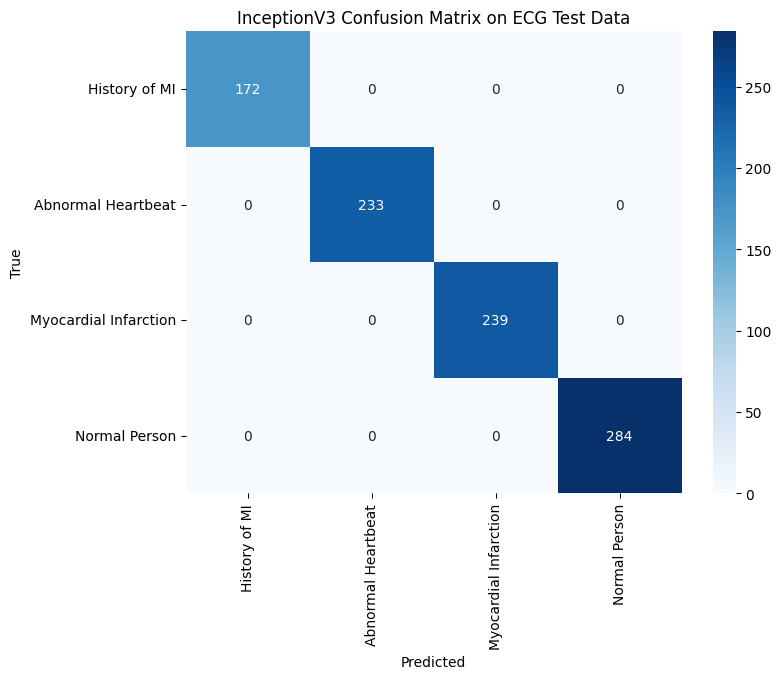

In [20]:
# Load best model
model.load_state_dict(torch.load("best_inceptionv3_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
], yticklabels=[
    "History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"
])
plt.title("InceptionV3 Confusion Matrix on ECG Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()